In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats.distributions import norm

### The Algorithm

Below is an implementation of an algorithm to calculate lagrange multipliers for applied ME problems. 

In [2]:
def ME(constraint, epsilon=1e-6, eta=1, max_iter=1000):
        
    def objective(lambda_):
        
        lambda_ = lambda_.reshape(1, -1)
        
        objective_trace = np.exp(np.dot(lambda_, constraint.T)).T # exp(<l, h(theta)>)
        gradient_trace = constraint * objective_trace # h(theta) * exp(<l, h(theta)>)

        objective = np.mean(objective_trace) # posterior expectation of exp(<l, h(theta)>)

        gradient = np.mean(gradient_trace, axis=0) / objective # posterior expectation of gradient of exp(<l, h(theta)>) 
        
        return gradient, np.log(objective)

    
    def print_state(i, lam, grad, objective_):
        print(
            f'iter {i} ' +
            f'|lambda| = {round(np.linalg.norm(lam), 6)} ' +
            f'|grad| = {round(np.linalg.norm(grad), 9)} '
        )

    lambda_ = np.zeros(constraint.shape[1])

    gradient, log_objective = objective(lambda_)
    previous_gradient = gradient

    i = 0

    print_state(i, lambda_, gradient, log_objective)

    while np.linalg.norm(gradient) > epsilon:

        lambda_ = lambda_ - eta * gradient
        gradient, log_objective = objective(lambda_)

        i += 1

        if np.linalg.norm(gradient) / np.linalg.norm(previous_gradient) < .1:
            previous_gradient = gradient
            print_state(i, lambda_, gradient, log_objective)

        if i >= max_iter:
            print(f'Max iterations ({max_iter}) exceeded')
            break

    print_state(i, lambda_, gradient, log_objective)

    weights = np.exp(np.dot(lambda_, constraint.T)).T / np.sum(np.exp(np.dot(lambda_, constraint.T)).T)
    
    return lambda_, weights, gradient
    
    

### Trace and Constraints

The goal is to demonstrate the effectiveness of this algorithm in applying an ME correction to a trace generated by an inference engine. Below, a trace is generated and visualized. Each color of the histogram represents a different parameter of the posterior. 

In [71]:
y = np.random.normal(1, 1, 10)

with pm.Model() as model:
    
    mu = pm.Flat('mu')
    sigma = pm.HalfFlat('sigma')
    
    pm.Normal('obs', mu=mu, sigma=sigma, observed=y)

In [72]:
with model:
    trace = pm.sample()
    
trace = pm.trace_to_dataframe(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8806421126051032, but should be close to 0.8. Try to increase the number of tuning steps.


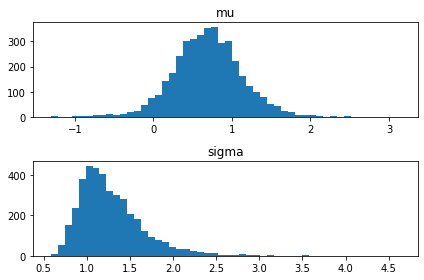

In [75]:
fig, ax = plt.subplots(2, 1)

ax[0].hist(trace['mu'], bins=50)
ax[0].set_title('mu')

ax[1].hist(trace['sigma'], bins=50)
ax[1].set_title('sigma')

plt.tight_layout()
plt.show()

Constraints are _holonomic_, meaning that they take the form $h(\theta_1, ..., \theta_n)=0$. Here, we have one constraint on the problem, namely,

$$h(\mu, \sigma) = \mu - \sigma = 0$$

which can be interpeted to mean that the two parameters ought to be equal in expectation. Below is a visualization of the posterior distrubutions of this constraint. Since it is holonomic, if it was satisfied it would show a distribution with a mean of 0.

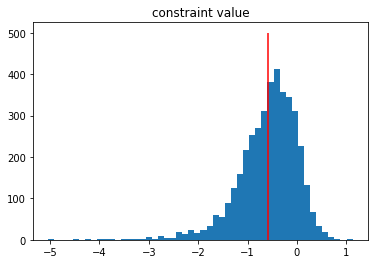

In [91]:
constraint = np.array(trace['mu'] - trace['sigma']).reshape(len(trace['mu']), 1)

plt.hist(constraint, bins=50)
plt.vlines(np.mean(constraint), 0, 500, colors='red')
plt.title('constraint value')
plt.show()

Since they are holonomic, we need to find lagrange multipliers $\lambda$ that make transform each of these distributions to have a mean of 0. To do that, we use the ME() function, which takes the constraint trace as an argument, along with a tolerance $\epsilon$, an optimization rate $\eta$, and the max number of descent iterations to reach tolerance.  

### Results

The algorithm implementation gives a running trace of the optimization state. The first state variable is the iteration, the second is the magnitude of the lagrange multiplier vector $|\lambda|$, and the third is the magnitude of the gradient of the objective function $|E[ \nabla_\lambda e^{\lambda \cdot h(\theta)}]|$ which indicates how close the corrected constraint distributions are to satisfying the holonomic property. A gradient of $|E[ \nabla_\lambda e^{\lambda \cdot h(\theta)}]| = 0$ means the constraints are satisfied.

In [92]:
lambda_, weights, gradient = ME(constraint)

iter 0 |lambda| = 0.0 |grad| = 0.588697261 
iter 11 |lambda| = 2.4351 |grad| = 0.056284561 
iter 25 |lambda| = 2.760677 |grad| = 0.005247432 
iter 39 |lambda| = 2.791429 |grad| = 0.000503065 
iter 53 |lambda| = 2.794381 |grad| = 4.8339e-05 
iter 67 |lambda| = 2.794664 |grad| = 4.646e-06 
iter 77 |lambda| = 2.794689 |grad| = 8.72e-07 


#### Lagrange Multipliers
The algorithm outputs three variables. The first is the multipliers $\lambda$, the second are the correction weights, and the third is the value of the objective function. For this problem, $\lambda$ is given below,

In [93]:
lambda_

array([2.79468869])

#### Weights

The weights can be used to calculate constrained posterior expectations. Given an unconstrained posterior trace of size $S$, $\{\theta_s\} \sim p(\theta|y)$, some expectation of interest, say $E_{\text{new}}[g(\theta)]$, can be approximated by 

$$ E_{\text{new}}[g(\theta)] = \frac{\int g(\theta) p(\theta | y) e^{\lambda \cdot h(\theta)} d\theta}{\int p(\theta | y) e^{\lambda \cdot h(\theta)} d\theta} \approx \frac{\sum_{s=1}^S g(\theta_s) e^{\lambda \cdot h(\theta_s)}}{\sum_{s=1}^S e^{\lambda \cdot h(\theta_s)}}$$

which is simply a weighted average of $g(\theta_s)$ with weights given by 

$$ w_s = \frac{e^{\lambda \cdot h(\theta_s)}}{\sum_{s=1}^S e^{\lambda \cdot h(\theta_s)}}$$

Therefore, the expectation can be approximated by 

$$ E_{\text{new}}[g(\theta)] = \sum_{s=1}^S w_s g(\theta_s) $$

#### Demonstration of Effectiveness

Using these weights, we can demonstrate that the algorithm is effective in performing the ME correction. The original posterior expections of the parameters are given below. Notice how the constraints are not satisfied; the first two parmeters are not equal in expectation, and the second two do not differ by 1 in expectation.

In [94]:
mu, sigma = trace.mean(axis=0)
mu, sigma

(0.6944120425785607, 1.2831093034094732)

Below are the constrained posterior expectations of the analysis. As you can see, the constrained expectations satisfy the holonomic constraints. The first two parameters are equal in expection, and the second two parameters differ by 1 in expectation. 

In [95]:
mu_new, sigma_new  = (trace * weights.reshape(-1,1)).sum(axis=0)
mu_new, sigma_new

(1.1292228285486667, 1.1292237004764085)

We can compare the Bayes Estimate likelihood to the ME-corrected Bayes Estimate likelihood to see how the extra information affected the inference when compared with the target distribution that the data was sampled from.

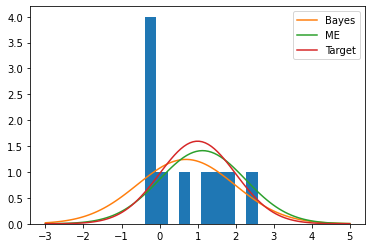

In [97]:
y_domain = np.linspace(-3, 5, 100)

plt.hist(y)

plt.plot(y_domain, 4 * norm.pdf(y_domain, mu, sigma), label='Bayes')
plt.plot(y_domain, 4 * norm.pdf(y_domain, mu_new, sigma_new), label='ME')
plt.plot(y_domain, 4 * norm.pdf(y_domain, 1, 1), label='Target')

plt.legend()

plt.show()